In [1]:
import os, json
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re

### Modelo base XGBoost

In [2]:
VERSION_TAG_XGB = "v1" 
BASE_XGB = "models_XGB"

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

df_base =df_vcr_c.copy()
obj_cols = df_base.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_base = df_base.drop(columns=cols_to_drop)

In [ ]:
# === Cargar artefactos ===
with open(os.path.join(BASE_XGB, f"feature_names_XGB_{VERSION_TAG_XGB}.json"), "r") as f:
    feat_xgb = json.load(f)

model_xgb = xgb.XGBRegressor()
model_xgb.load_model(os.path.join(BASE_XGB, f"XGB_model_{VERSION_TAG_XGB}.json"))

DF = df_base.copy()
X_all = DF[feat_xgb].values.astype(np.float32)

# (Sub)muestras para explicación
EX_N = 1000
X_explain = X_all[:EX_N]

# === SHAP TreeExplainer (rápido y exacto para árboles) ===
explainer_xgb = shap.TreeExplainer(model_xgb, feature_perturbation="tree_path_dependent", model_output="raw")
shap_vals_xgb = explainer_xgb.shap_values(X_explain)

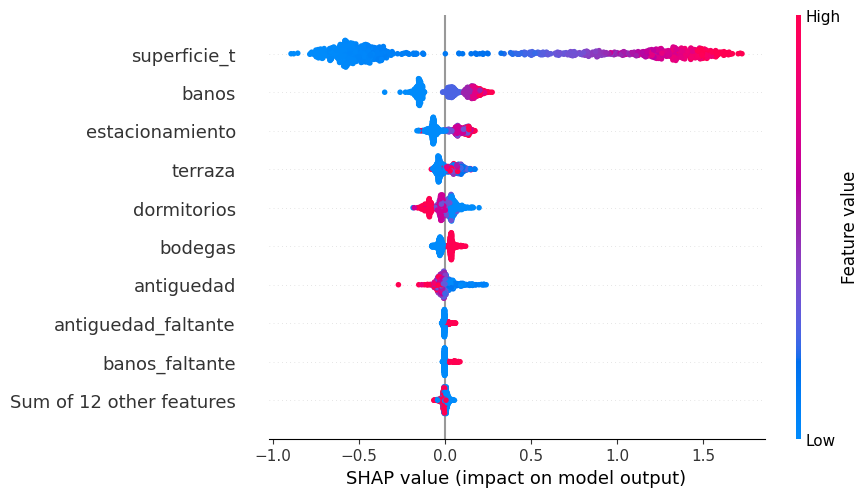

In [6]:
# Crea el objeto Explanation (opcional si explainer ya devuelve esto)
shap_values_xgb = shap.Explanation(
    values=shap_vals_xgb,
    base_values=explainer_xgb.expected_value,
    data=X_explain,
    feature_names=feat_xgb
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_xgb, show=True)


In [7]:
# === Importancias y Top-K con signo (XGBoost) ===
mean_shap_xgb = np.mean(shap_vals_xgb, axis=0)                # efecto promedio (firmado)
imp_xgb = np.mean(np.abs(shap_vals_xgb), axis=0)               # importancia global (abs)
order_xgb = np.argsort(imp_xgb)[::-1]
TOPK = 20

sign_char_xgb = np.where(mean_shap_xgb >= 0, "+", "-")

shap_top_xgb = pd.DataFrame({
    "feature": np.array(feat_xgb)[order_xgb][:TOPK],
    "sign": sign_char_xgb[order_xgb][:TOPK],
    "mean_|shap|": imp_xgb[order_xgb][:TOPK],
    "mean_shap": mean_shap_xgb[order_xgb][:TOPK],              # magnitud firmada (opcional)
})

print("\n[XGB] Top-20 features por |SHAP| con signo:")
print(shap_top_xgb.to_string(index=False))


[XGB] Top-20 features por |SHAP| con signo:
             feature sign  mean_|shap|  mean_shap
        superficie_t    +     0.833067   0.312987
               banos    +     0.131190   0.014911
     estacionamiento    +     0.081694   0.014677
             terraza    +     0.048885   0.016793
         dormitorios    -     0.048460  -0.005293
             bodegas    +     0.036127   0.006340
          antiguedad    +     0.032402   0.000546
 antiguedad_faltante    -     0.008124  -0.000253
      banos_faltante    -     0.007086  -0.000023
                Or_O    +     0.006202   0.000629
         Or_Faltante    -     0.003431  -0.000296
   flag_Departamento    -     0.002846  -0.000539
                Or_E    +     0.002423   0.000109
       flag_Semipiso    +     0.001503   0.000613
                Or_S    +     0.001220   0.000062
                Or_N    -     0.001146  -0.000161
dormitorios_faltante    -     0.000742  -0.000214
     flag_Multinivel    -     0.000450  -0.000168
     

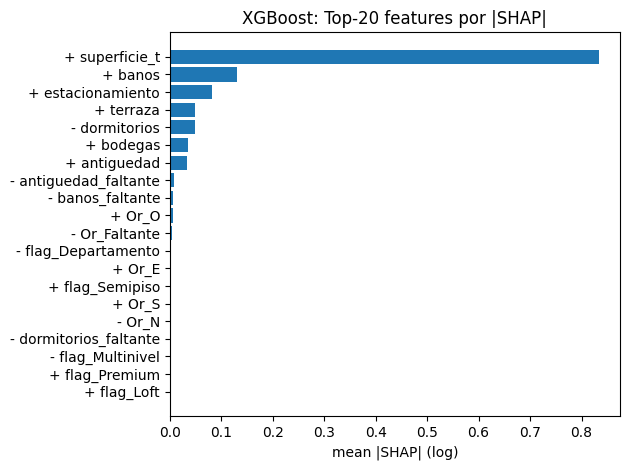

In [7]:
# === Gráfico Top-K (con signo en la etiqueta) ===
top = shap_top_xgb.copy()
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("XGBoost: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()

### Modelo con coordenadas XGBoost

In [8]:
VERSION_TAG_XGB = "v2" 
BASE_XGB = "models_XGB"

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

#Configuración específica del modelo
df_coord =df_vcr_c.copy()
obj_cols = df_coord.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_coord = df_coord.drop(columns=cols_to_drop)

In [ ]:
# === Cargar artefactos ===
with open(os.path.join(BASE_XGB, f"feature_names_XGB_{VERSION_TAG_XGB}.json"), "r") as f:
    feat_xgb = json.load(f)

model_xgb = xgb.XGBRegressor()
model_xgb.load_model(os.path.join(BASE_XGB, f"XGB_model_{VERSION_TAG_XGB}.json"))

DF = df_coord.copy()
X_all = DF[feat_xgb].values.astype(np.float32)

# (Sub)muestras para explicación
EX_N = 1000
X_explain = X_all[:EX_N]

# === SHAP TreeExplainer (rápido y exacto para árboles) ===
explainer_xgb = shap.TreeExplainer(model_xgb, feature_perturbation="tree_path_dependent", model_output="raw")
shap_vals_xgb = explainer_xgb.shap_values(X_explain)

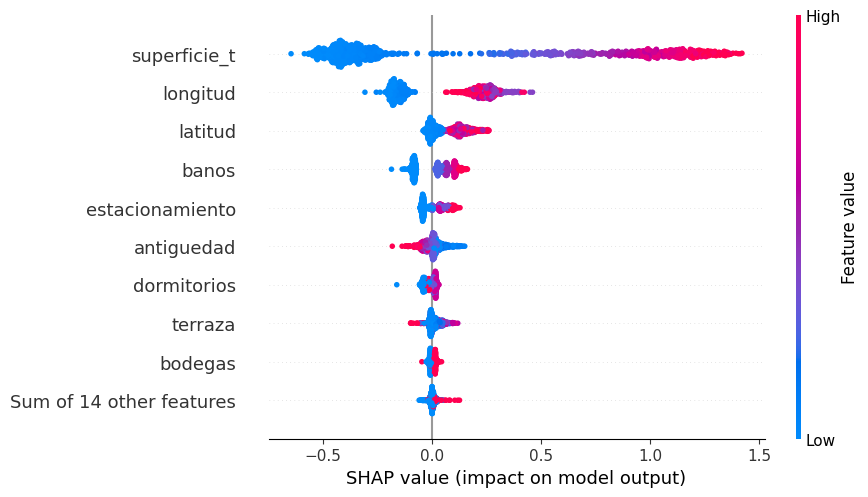

In [10]:
# Crea el objeto Explanation (opcional si explainer ya devuelve esto)
shap_values_xgb = shap.Explanation(
    values=shap_vals_xgb,
    base_values=explainer_xgb.expected_value,
    data=X_explain,
    feature_names=feat_xgb
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_xgb, show=True)


In [ ]:
# === Importancias y Top-K con signo (XGBoost) ===
mean_shap_xgb = np.mean(shap_vals_xgb, axis=0)                # efecto promedio (firmado)
imp_xgb = np.mean(np.abs(shap_vals_xgb), axis=0)               # importancia global (abs)
order_xgb = np.argsort(imp_xgb)[::-1]
TOPK = 20

sign_char_xgb = np.where(mean_shap_xgb >= 0, "+", "-")

shap_top_xgb = pd.DataFrame({
    "feature": np.array(feat_xgb)[order_xgb][:TOPK],
    "sign": sign_char_xgb[order_xgb][:TOPK],
    "mean_|shap|": imp_xgb[order_xgb][:TOPK],
    "mean_shap": mean_shap_xgb[order_xgb][:TOPK],              # magnitud firmada (opcional)
})

print("\n[XGB] Top-20 features por |SHAP| con signo:")
print(shap_top_xgb.to_string(index=False))


[XGB] Top-20 features por |SHAP| con signo:
             feature sign  mean_|shap|  mean_shap
        superficie_t    +     0.644421   0.264224
            longitud    +     0.201879   0.040822
             latitud    +     0.077676   0.070790
               banos    +     0.077004   0.011523
     estacionamiento    +     0.048078   0.010804
          antiguedad    +     0.030889   0.001105
         dormitorios    -     0.020036  -0.009392
             terraza    +     0.019327   0.010068
             bodegas    +     0.011437   0.002552
 antiguedad_faltante    -     0.002834  -0.000574
         Or_Faltante    +     0.002369   0.000129
                Or_N    -     0.002362  -0.000026
                Or_O    +     0.002294   0.000198
       flag_Semipiso    +     0.002155   0.000643
   flag_Departamento    -     0.001891  -0.000350
      banos_faltante    -     0.001409  -0.000281
                Or_E    +     0.001326   0.000429
                Or_S    -     0.001152  -0.000065
dormi

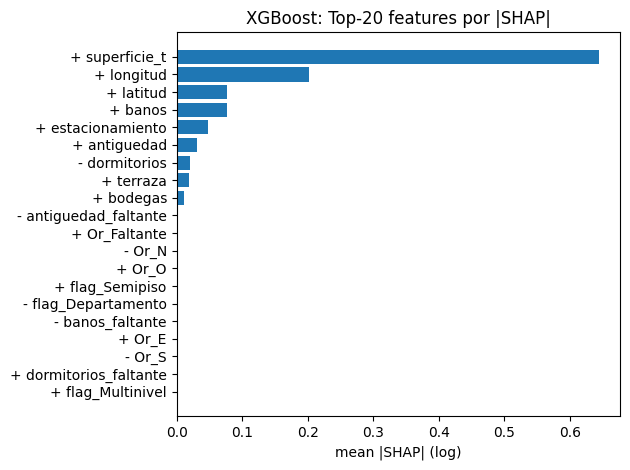

In [12]:
# === Gráfico Top-K (con signo en la etiqueta) ===
top = shap_top_xgb.copy()
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("XGBoost: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()

### Modelo con coordenadas y VCR XGBoost

In [13]:
VERSION_TAG_XGB = "v3" # ajusta: v1/v2/v3
BASE_XGB = "models_XGB"

df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])

df_vcr =df_vcr_e.copy()
obj_cols = df_vcr.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_vcr = df_vcr.drop(columns=cols_to_drop)

In [14]:
# Configuración 
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# %% Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out


df_vcr_imp = impute_vcr_semantic(df_vcr)
df_vcr_imp.info()  


Imputación VCR completada. NaNs antes: 246,228 -> después: 0
<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Columns: 194 entries, monto to has_bus
dtypes: float64(161), int64(33)
memory usage: 37.5 MB


In [ ]:
# === Cargar artefactos ===
with open(os.path.join(BASE_XGB, f"feature_names_XGB_{VERSION_TAG_XGB}.json"), "r") as f:
    feat_xgb = json.load(f)

model_xgb = xgb.XGBRegressor()
model_xgb.load_model(os.path.join(BASE_XGB, f"XGB_model_{VERSION_TAG_XGB}.json"))

DF = df_vcr_imp.copy()
X_all = DF[feat_xgb].values.astype(np.float32)

# (Sub)muestras para explicación
EX_N = 1000
X_explain = X_all[:EX_N]

# === SHAP TreeExplainer (rápido y exacto para árboles) ===
explainer_xgb = shap.TreeExplainer(model_xgb, feature_perturbation="tree_path_dependent", model_output="raw")
shap_vals_xgb = explainer_xgb.shap_values(X_explain)

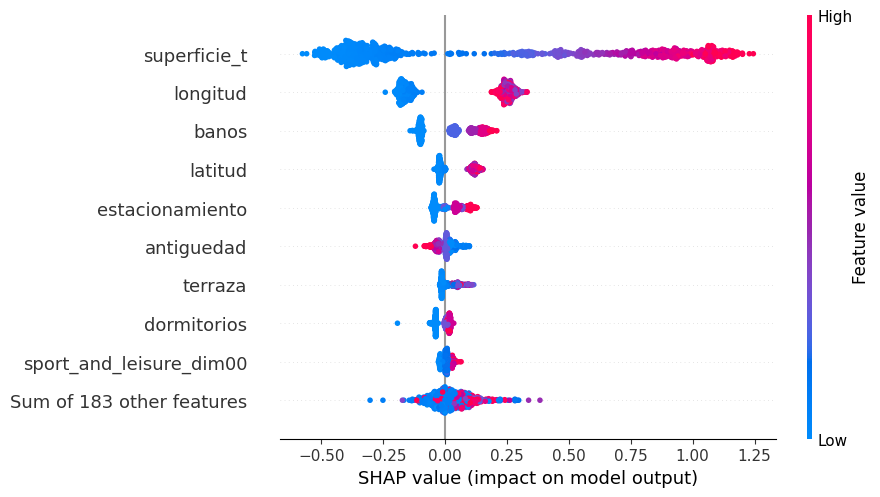

In [16]:
# Crea el objeto Explanation (opcional si explainer ya devuelve esto)
shap_values_xgb = shap.Explanation(
    values=shap_vals_xgb,
    base_values=explainer_xgb.expected_value,
    data=X_explain,
    feature_names=feat_xgb
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_xgb, show=True)


In [ ]:
# === Importancias y Top-K con signo (XGBoost) ===
mean_shap_xgb = np.mean(shap_vals_xgb, axis=0)                # efecto promedio (firmado)
imp_xgb = np.mean(np.abs(shap_vals_xgb), axis=0)               # importancia global (abs)
order_xgb = np.argsort(imp_xgb)[::-1]
TOPK = 20

sign_char_xgb = np.where(mean_shap_xgb >= 0, "+", "-")

shap_top_xgb = pd.DataFrame({
    "feature": np.array(feat_xgb)[order_xgb][:TOPK],
    "sign": sign_char_xgb[order_xgb][:TOPK],
    "mean_|shap|": imp_xgb[order_xgb][:TOPK],
    "mean_shap": mean_shap_xgb[order_xgb][:TOPK],              # magnitud firmada (opcional)
})

print("\n[XGB] Top-20 features por |SHAP| con signo:")
print(shap_top_xgb.to_string(index=False))


[XGB] Top-20 features por |SHAP| con signo:
                feature sign  mean_|shap|  mean_shap
           superficie_t    +     0.566894   0.229582
               longitud    +     0.207717   0.046428
                  banos    +     0.100611   0.024279
                latitud    +     0.070470   0.049301
        estacionamiento    +     0.051219   0.012847
             antiguedad    +     0.025024   0.000021
                terraza    +     0.024273   0.011677
            dormitorios    -     0.021280  -0.003801
sport_and_leisure_dim00    +     0.013573   0.005164
sport_and_leisure_dim03    +     0.009631   0.003080
         security_dim08    +     0.009027   0.000682
                bodegas    +     0.008270   0.001581
sport_and_leisure_dim08    +     0.007075   0.002856
   education_prim_dim00    +     0.006243   0.002861
         security_dim00    -     0.006092  -0.000764
    education_sup_dim00    -     0.004800  -0.000805
   food_and_drink_dim00    +     0.003648   0.001446
 

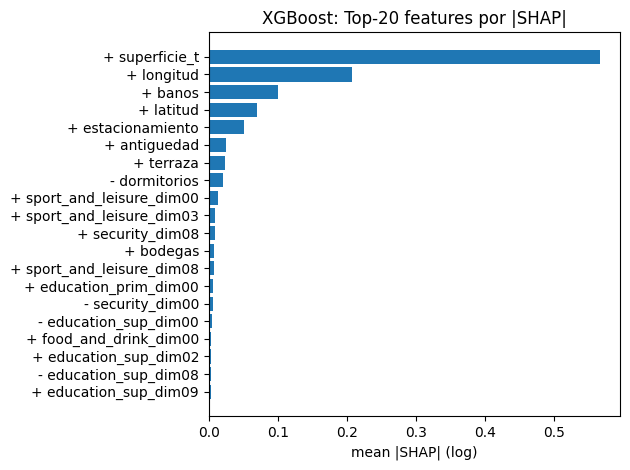

In [18]:
# === Gráfico Top-K (con signo en la etiqueta) ===
top = shap_top_xgb.copy()
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("XGBoost: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()